In [115]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.api import OLS
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, precision_recall_curve, recall_score, accuracy_score, roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
import statsmodels.api as sm

In [116]:
# read all tables
customers = pd.read_csv('https://raw.githubusercontent.com/delinai/schulich_ds1_2024/main/Datasets/customers_final.csv')
engagement = pd.read_csv('https://raw.githubusercontent.com/delinai/schulich_ds1_2024/main/Datasets/engagements_final.csv')
marketing = pd.read_csv('https://raw.githubusercontent.com/delinai/schulich_ds1_2024/main/Datasets/marketing_final.csv')
transactions = pd.read_csv('https://raw.githubusercontent.com/delinai/schulich_ds1_2024/main/Datasets/transactions_final.csv')

In [117]:
# customers table check
# this table holds demographic information and is at a CUSTOMER level
# it has 10,000 entries, as we have 10,000 customers
customers.head()

,customer_id,join_date,last_purchase_date,age,gender,location
0,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury
1,2,2021-09-08,2023-10-25,NaN,Male,Hillville
2,3,2021-06-01,2022-11-27,NaN,NaN,North Latoyatown
3,4,2022-01-01,2022-09-01,29.0,Male,Grossstad
4,5,2022-01-24,2023-06-02,NaN,Male,East Matthewfort


In [118]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   customer_id         10000 non-null  int64  
 1   join_date           10000 non-null  object 
 2   last_purchase_date  10000 non-null  object 
 3   age                 8991 non-null   float64
 4   gender              9467 non-null   object 
 5   location            10000 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 468.9+ KB


In [119]:
# engagement table check
# this table holds aggregate CUSTOMER level data on the number of site visits, emails opened and clicks
# it also has 10,000 rows, one for each customer
engagement.head()

,customer_id,number_of_site_visits,number_of_emails_opened,number_of_clicks
0,1,10,15,1
1,2,285,49,51
2,3,192,73,25
3,4,110,30,17
4,5,161,2,7


In [120]:
engagement.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 4 columns):
 #   Column                   Non-Null Count  Dtype
---  ------                   --------------  -----
 0   customer_id              10000 non-null  int64
 1   number_of_site_visits    10000 non-null  int64
 2   number_of_emails_opened  10000 non-null  int64
 3   number_of_clicks         10000 non-null  int64
dtypes: int64(4)
memory usage: 312.6 KB


In [121]:
# marketing table check
# this table is at a CAMPAIGN ID level. It has 25,200 rows which means each customer will have MULTIPLE marketing offers
# this table captures if the customer responded to the offer or not
# Consider aggregating this table at a customer level (e.g., you could aggregate based on number of campaigns they responded YES to, or the most common campaign they responded to, etc.)
marketing.head()

,campaign_id,customer_id,response,promotion_type,campaign_date
0,1,1,No,Buy One Get One,2024-02-29
1,2,1,No,Discount,2024-01-24
2,3,1,No,Free Shipping,2024-03-05
3,4,1,Yes,Buy One Get One,2024-01-10
4,5,2,Yes,Free Shipping,2022-07-08


In [122]:
marketing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25200 entries, 0 to 25199
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   campaign_id     25200 non-null  int64 
 1   customer_id     25200 non-null  int64 
 2   response        25200 non-null  object
 3   promotion_type  25200 non-null  object
 4   campaign_date   25200 non-null  object
dtypes: int64(2), object(3)
memory usage: 984.5+ KB


In [123]:
# transaction data check
# this table is at a TRANSACTION ID level, and has 129,545 rows, meaning each customer has multiple transactions
# you will use this table to calculate LTV. Hint: you should SUM all transaction amounts PER customer, to calculate total LTV
# you can use the other features (like last transaction date) to calculate their customer age (e.g., time between join date and last transaction date)
# you could also consider feature engineering a favourite category for example
# consider using RFM framework to assess the recency, frequency, or monetary value of transactions to create segments
transactions.head()

,transaction_id,customer_id,transaction_date,transaction_amount,product_category
0,1,1,2024-02-03,165.56,Clothing
1,2,1,2024-03-02,699.01,Home Goods
2,3,1,2024-03-12,146.86,Home Goods
3,4,1,2024-01-20,927.46,Electronics
4,5,1,2024-02-25,1395.87,Electronics


In [124]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129545 entries, 0 to 129544
Data columns (total 5 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   transaction_id      129545 non-null  int64  
 1   customer_id         129545 non-null  int64  
 2   transaction_date    129545 non-null  object 
 3   transaction_amount  129545 non-null  float64
 4   product_category    129545 non-null  object 
dtypes: float64(1), int64(2), object(2)
memory usage: 4.9+ MB


### OPTION 1: Join at Customer level

In [125]:
# joining tables together
# all tables can be joined on the customer ID
# you can aggregate data in individual tables first, at a customer level, then join
# or you can join and have a mega table at a transaction level

In [126]:
# example 1: join at customer level with # of marketing campaigns customer responded YES to
# step 1: marketing data at a customer level

marketing_agg = marketing[marketing['response']=='Yes'].groupby('customer_id')['campaign_id'].count().to_frame()

In [127]:
# step 2: aggregate transaction data at a customer level
transactions_agg = transactions.groupby('customer_id').aggregate({'transaction_id':'count','transaction_amount':'sum'})

In [128]:
# step 3: set customers and engagement index as customer_id
customers.set_index('customer_id', inplace=True)
engagement.set_index('customer_id', inplace=True)

In [129]:
# step 4: join all tables
joint_data = customers.join(engagement).join(transactions_agg).join(marketing_agg)

In [130]:
# now you have a customer level data set;  you will see some NaN values under campaign_id because some customers haven't been targeted with any marketing campaigns
joint_data

,join_date,last_purchase_date,age,gender,location,number_of_site_visits,number_of_emails_opened,number_of_clicks,transaction_id,transaction_amount,campaign_id
customer_id,,,,,,,,,,,
1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,6,3509.48,1.0
2,2021-09-08,2023-10-25,NaN,Male,Hillville,285,49,51,9,6081.32,2.0
3,2021-06-01,2022-11-27,NaN,NaN,North Latoyatown,192,73,25,6,1454.87,1.0
4,2022-01-01,2022-09-01,29.0,Male,Grossstad,110,30,17,20,7874.68,1.0
5,2022-01-24,2023-06-02,NaN,Male,East Matthewfort,161,2,7,24,15524.55,NaN
...,...,...,...,...,...,...,...,...,...,...,...
9996,2022-12-16,2023-08-13,42.0,Female,Johnstonborough,119,47,16,10,5498.20,NaN
9997,2022-07-09,2023-01-25,26.0,Male,Jessicamouth,3,33,14,12,5848.30,1.0
9998,2023-09-17,2024-01-30,39.0,Male,New John,53,17,5,3,3503.13,1.0


## Data Cleaning 


## Rename Column - easier to understand
### CLV: transaction_id -> transaction_count
### campaign_id -> campaign_count

In [131]:
joint_data.rename(columns={'transaction_id': 'transaction_count', 'campaign_id': 'campaign_count'}, inplace=True)
joint_data

,join_date,last_purchase_date,age,gender,location,number_of_site_visits,number_of_emails_opened,number_of_clicks,transaction_count,transaction_amount,campaign_count
customer_id,,,,,,,,,,,
1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,6,3509.48,1.0
2,2021-09-08,2023-10-25,NaN,Male,Hillville,285,49,51,9,6081.32,2.0
3,2021-06-01,2022-11-27,NaN,NaN,North Latoyatown,192,73,25,6,1454.87,1.0
4,2022-01-01,2022-09-01,29.0,Male,Grossstad,110,30,17,20,7874.68,1.0
5,2022-01-24,2023-06-02,NaN,Male,East Matthewfort,161,2,7,24,15524.55,NaN
...,...,...,...,...,...,...,...,...,...,...,...
9996,2022-12-16,2023-08-13,42.0,Female,Johnstonborough,119,47,16,10,5498.20,NaN
9997,2022-07-09,2023-01-25,26.0,Male,Jessicamouth,3,33,14,12,5848.30,1.0
9998,2023-09-17,2024-01-30,39.0,Male,New John,53,17,5,3,3503.13,1.0


## Imputing
#### Handle NA:

In [132]:
# NA 
joint_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 1 to 10000
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   join_date                10000 non-null  object 
 1   last_purchase_date       10000 non-null  object 
 2   age                      8991 non-null   float64
 3   gender                   9467 non-null   object 
 4   location                 10000 non-null  object 
 5   number_of_site_visits    10000 non-null  int64  
 6   number_of_emails_opened  10000 non-null  int64  
 7   number_of_clicks         10000 non-null  int64  
 8   transaction_count        10000 non-null  int64  
 9   transaction_amount       10000 non-null  float64
 10  campaign_count           7665 non-null   float64
dtypes: float64(3), int64(4), object(4)
memory usage: 937.5+ KB


In [133]:
joint_data.isnull().sum()

join_date                     0
last_purchase_date            0
age                        1009
gender                      533
location                      0
number_of_site_visits         0
number_of_emails_opened       0
number_of_clicks              0
transaction_count             0
transaction_amount            0
campaign_count             2335
dtype: int64

In [134]:
gender_type = joint_data['gender'].value_counts()
gender_type.sort_values()

gender
Female    4698
Male      4769
Name: count, dtype: int64

In [135]:
age_num =  joint_data['age'].value_counts()
age_num

age
25.0    199
62.0    195
26.0    195
52.0    193
67.0    192
36.0    191
21.0    189
51.0    188
59.0    188
22.0    186
20.0    185
41.0    185
64.0    184
30.0    183
60.0    183
53.0    183
43.0    181
58.0    181
35.0    180
68.0    177
19.0    177
28.0    173
47.0    172
49.0    172
45.0    171
34.0    169
48.0    169
32.0    168
46.0    167
39.0    167
37.0    167
63.0    166
24.0    166
50.0    166
69.0    166
56.0    165
31.0    164
29.0    164
18.0    163
33.0    163
65.0    163
55.0    163
66.0    162
57.0    162
27.0    161
44.0    160
40.0    160
38.0    156
61.0    156
23.0    155
54.0    152
42.0    148
Name: count, dtype: int64

In [136]:
campaign_count_num = joint_data['campaign_count'].value_counts()
campaign_count_num

campaign_count
1.0    4011
2.0    2563
3.0     923
4.0     168
Name: count, dtype: int64

#### For Gender, we have to substituent the missing values with mode. Because the percentage of the missing value is very small (533/ 10000) and there'are only 2 types of data in this column

In [137]:
# find the most frequent gender type
mode_gender = joint_data['gender'].mode()[0]
mode_gender

'Male'

In [138]:
# Replace missing value with mode_gender
joint_data['gender'].fillna(mode_gender, inplace=True)

/var/folders/40/4gqysqf51wb4jhqgmxdldv8r0000gn/T/ipykernel_20745/688987356.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  joint_data['gender'].fillna(mode_gender, inplace=True)


#### For Age, we first need to determine which value we want to use to fill up the missing value or drop them

<Axes: xlabel='age', ylabel='Count'>

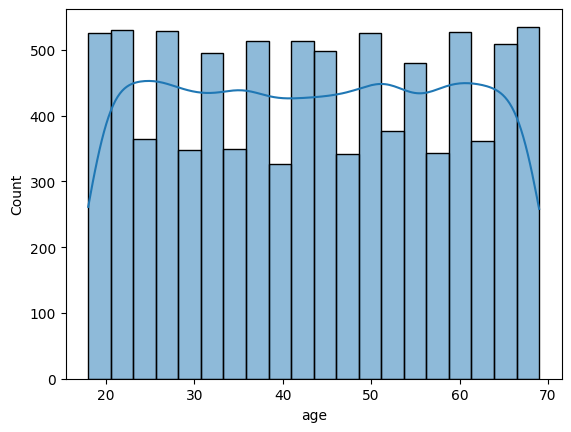

In [139]:
sns.histplot(joint_data['age'], kde=True)

<Axes: ylabel='age'>

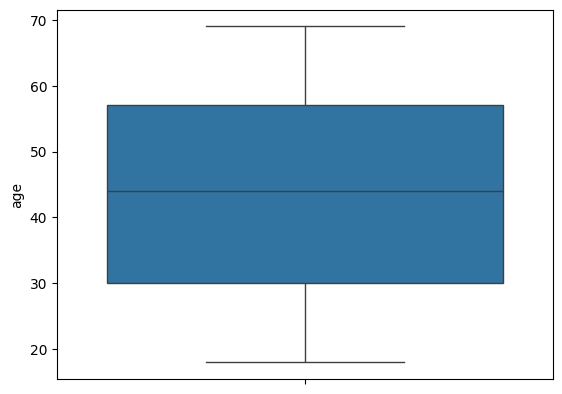

In [140]:
sns.boxplot(joint_data['age'])

In [141]:
mean_age = joint_data['age'].mean()
mean_age

43.467467467467465

In [142]:
median_age = joint_data['age'].median()
median_age

44.0

In [143]:
mode_age = joint_data['age'].mode()
mode_age

0    25.0
Name: age, dtype: float64

#### From the boxplot and histogram we can see the data in the age group is almost evenly distributed, the mode will not be good for us to use to fit the missing value and the mean might be influenced by the extreme values. 
#### In this case, we gonna use the median to fill up the missing values.

In [144]:
joint_data['age'].fillna(median_age, inplace=True)

/var/folders/40/4gqysqf51wb4jhqgmxdldv8r0000gn/T/ipykernel_20745/1904810411.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  joint_data['age'].fillna(median_age, inplace=True)


#### For campaign_count, we have to substituent the missing values with 0 as the customers is not participating the activities we hold.

In [145]:
joint_data['campaign_count'].fillna(0, inplace=True)

/var/folders/40/4gqysqf51wb4jhqgmxdldv8r0000gn/T/ipykernel_20745/2710180546.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  joint_data['campaign_count'].fillna(0, inplace=True)


### then, we want to check if there's still any missing values(NA)

In [146]:
print(str(joint_data.isnull().values.sum()) + ' NAs')
assert joint_data.isnull().values.sum() == 0, "There are still missing values remaining!"

0 NAs


In [147]:
joint_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 1 to 10000
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   join_date                10000 non-null  object 
 1   last_purchase_date       10000 non-null  object 
 2   age                      10000 non-null  float64
 3   gender                   10000 non-null  object 
 4   location                 10000 non-null  object 
 5   number_of_site_visits    10000 non-null  int64  
 6   number_of_emails_opened  10000 non-null  int64  
 7   number_of_clicks         10000 non-null  int64  
 8   transaction_count        10000 non-null  int64  
 9   transaction_amount       10000 non-null  float64
 10  campaign_count           10000 non-null  float64
dtypes: float64(3), int64(4), object(4)
memory usage: 937.5+ KB


In [148]:
joint_data.describe()

,age,number_of_site_visits,number_of_emails_opened,number_of_clicks,transaction_count,transaction_amount,campaign_count
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,43.521200,100.111900,39.862100,19.725300,12.954500,7737.562981,1.257800
std,14.313443,118.625052,46.511719,22.975083,7.191203,4628.799469,0.971511
min,18.000000,1.000000,1.000000,1.000000,1.000000,23.810000,0.000000
25%,32.000000,15.000000,6.000000,3.000000,7.000000,3839.915000,1.000000
50%,44.000000,53.000000,22.000000,11.000000,13.000000,7498.890000,1.000000
75%,55.000000,141.000000,57.000000,28.000000,19.000000,11275.797500,2.000000
max,69.000000,711.000000,303.000000,142.000000,25.000000,24298.220000,4.000000


## Feature Encoding and New Feature Generation

### one-hot encoding 
#### Location -> One-Hot Encoding

In [149]:
location_counts = joint_data['location'].value_counts().reset_index()
location_counts = pd.DataFrame(location_counts)
location_counts

,location,count
0,Lake James,15
1,North Christopher,12
2,Port John,11
3,West David,11
4,New John,10
...,...,...
7690,Adamstown,1
7691,Lake Deborahburgh,1
7692,New Joanna,1
7693,New Lynnburgh,1


In [150]:
one_hot_encoded = pd.get_dummies(joint_data['location'], prefix='location')
one_hot_encoded = one_hot_encoded.astype(int)
one_hot_encoded

,location_Aaronborough,location_Aaronburgh,location_Aaronbury,location_Aaronfurt,location_Aaronland,location_Aarontown,location_Aaronview,location_Aaronville,location_Abbottland,location_Abbottside,...,location_Zacharytown,location_Zacharyview,location_Zacharyville,location_Zamoraberg,location_Zhangport,location_Zimmermanfort,location_Zimmermanland,location_Zimmermanmouth,location_Zoeshire,location_Zunigaburgh
customer_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [151]:
# Add the one-hot encoded columns to the original DataFrame and remove the original 'location' column 
joint_data = pd.concat([joint_data, one_hot_encoded], axis=1)
joint_data.drop(columns=['location'], inplace=True)
joint_data

,join_date,last_purchase_date,age,gender,number_of_site_visits,number_of_emails_opened,number_of_clicks,transaction_count,transaction_amount,campaign_count,...,location_Zacharytown,location_Zacharyview,location_Zacharyville,location_Zamoraberg,location_Zhangport,location_Zimmermanfort,location_Zimmermanland,location_Zimmermanmouth,location_Zoeshire,location_Zunigaburgh
customer_id,,,,,,,,,,,,,,,,,,,,,
1,2023-11-20,2024-03-17,56.0,Female,10,15,1,6,3509.48,1.0,...,0,0,0,0,0,0,0,0,0,0
2,2021-09-08,2023-10-25,44.0,Male,285,49,51,9,6081.32,2.0,...,0,0,0,0,0,0,0,0,0,0
3,2021-06-01,2022-11-27,44.0,Male,192,73,25,6,1454.87,1.0,...,0,0,0,0,0,0,0,0,0,0
4,2022-01-01,2022-09-01,29.0,Male,110,30,17,20,7874.68,1.0,...,0,0,0,0,0,0,0,0,0,0
5,2022-01-24,2023-06-02,44.0,Male,161,2,7,24,15524.55,0.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9996,2022-12-16,2023-08-13,42.0,Female,119,47,16,10,5498.20,0.0,...,0,0,0,0,0,0,0,0,0,0
9997,2022-07-09,2023-01-25,26.0,Male,3,33,14,12,5848.30,1.0,...,0,0,0,0,0,0,0,0,0,0
9998,2023-09-17,2024-01-30,39.0,Male,53,17,5,3,3503.13,1.0,...,0,0,0,0,0,0,0,0,0,0


#### Gender -> One-Hot Encoding

<Axes: xlabel='gender', ylabel='Count'>

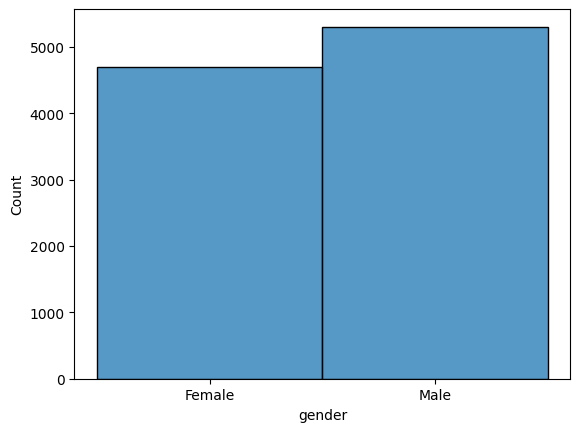

In [152]:
sns.histplot(joint_data['gender'])

In [153]:
g_one_hot_encoded = pd.get_dummies(joint_data['gender'], prefix='gender')
g_one_hot_encoded = g_one_hot_encoded.astype(int)
g_one_hot_encoded

,gender_Female,gender_Male
customer_id,,
1,1,0
2,0,1
3,0,1
4,0,1
5,0,1
...,...,...
9996,1,0
9997,0,1
9998,0,1


In [154]:
# Add the one-hot encoded columns to the original DataFrame and remove  the original 'gender' column 
joint_data = pd.concat([joint_data, g_one_hot_encoded], axis=1)
joint_data.drop(columns=['gender'], inplace=True)
joint_data

,join_date,last_purchase_date,age,number_of_site_visits,number_of_emails_opened,number_of_clicks,transaction_count,transaction_amount,campaign_count,location_Aaronborough,...,location_Zacharyville,location_Zamoraberg,location_Zhangport,location_Zimmermanfort,location_Zimmermanland,location_Zimmermanmouth,location_Zoeshire,location_Zunigaburgh,gender_Female,gender_Male
customer_id,,,,,,,,,,,,,,,,,,,,,
1,2023-11-20,2024-03-17,56.0,10,15,1,6,3509.48,1.0,0,...,0,0,0,0,0,0,0,0,1,0
2,2021-09-08,2023-10-25,44.0,285,49,51,9,6081.32,2.0,0,...,0,0,0,0,0,0,0,0,0,1
3,2021-06-01,2022-11-27,44.0,192,73,25,6,1454.87,1.0,0,...,0,0,0,0,0,0,0,0,0,1
4,2022-01-01,2022-09-01,29.0,110,30,17,20,7874.68,1.0,0,...,0,0,0,0,0,0,0,0,0,1
5,2022-01-24,2023-06-02,44.0,161,2,7,24,15524.55,0.0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9996,2022-12-16,2023-08-13,42.0,119,47,16,10,5498.20,0.0,0,...,0,0,0,0,0,0,0,0,1,0
9997,2022-07-09,2023-01-25,26.0,3,33,14,12,5848.30,1.0,0,...,0,0,0,0,0,0,0,0,0,1
9998,2023-09-17,2024-01-30,39.0,53,17,5,3,3503.13,1.0,0,...,0,0,0,0,0,0,0,0,0,1


### Finding the days since the customers joined & days since they last purchased.

In [155]:
import datetime

In [156]:
# finding the current datetime
current_dt = datetime.datetime.now()

In [157]:
# convert the join_date columns into datetime format
joint_data['join_date'] = pd.to_datetime(joint_data['join_date'], errors='coerce')

In [158]:
# find the days since they joined us
joint_data['days_since_joined'] = (current_dt - joint_data['join_date']).dt.days

In [159]:
# convert the last_purchase_date columns into datetime format
joint_data['last_purchase_date'] = pd.to_datetime(joint_data['last_purchase_date'], errors='coerce')

In [160]:
# find the days since their last purchase 
joint_data['days_since_last_purchase'] = (current_dt - joint_data['last_purchase_date']).dt.days
joint_data

,join_date,last_purchase_date,age,number_of_site_visits,number_of_emails_opened,number_of_clicks,transaction_count,transaction_amount,campaign_count,location_Aaronborough,...,location_Zhangport,location_Zimmermanfort,location_Zimmermanland,location_Zimmermanmouth,location_Zoeshire,location_Zunigaburgh,gender_Female,gender_Male,days_since_joined,days_since_last_purchase
customer_id,,,,,,,,,,,,,,,,,,,,,
1,2023-11-20,2024-03-17,56.0,10,15,1,6,3509.48,1.0,0,...,0,0,0,0,0,0,1,0,239,121
2,2021-09-08,2023-10-25,44.0,285,49,51,9,6081.32,2.0,0,...,0,0,0,0,0,0,0,1,1042,265
3,2021-06-01,2022-11-27,44.0,192,73,25,6,1454.87,1.0,0,...,0,0,0,0,0,0,0,1,1141,597
4,2022-01-01,2022-09-01,29.0,110,30,17,20,7874.68,1.0,0,...,0,0,0,0,0,0,0,1,927,684
5,2022-01-24,2023-06-02,44.0,161,2,7,24,15524.55,0.0,0,...,0,0,0,0,0,0,0,1,904,410
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9996,2022-12-16,2023-08-13,42.0,119,47,16,10,5498.20,0.0,0,...,0,0,0,0,0,0,1,0,578,338
9997,2022-07-09,2023-01-25,26.0,3,33,14,12,5848.30,1.0,0,...,0,0,0,0,0,0,0,1,738,538
9998,2023-09-17,2024-01-30,39.0,53,17,5,3,3503.13,1.0,0,...,0,0,0,0,0,0,0,1,303,168


### Finding the average transaction of each customer's purchase

In [161]:
joint_data['ave_purchase_price_amount'] = joint_data['transaction_amount'] / joint_data['transaction_count']

### Finding the frequency of each customer's purchase from they've join to now

In [162]:
joint_data['purchase_freq'] = joint_data['days_since_joined']/joint_data['transaction_count'] 

### Finding the conversion rate of users buying in web browsing

In [163]:
joint_data['coversion_rate'] = joint_data['number_of_site_visits'] / joint_data['transaction_amount']

In [164]:
joint_data

,join_date,last_purchase_date,age,number_of_site_visits,number_of_emails_opened,number_of_clicks,transaction_count,transaction_amount,campaign_count,location_Aaronborough,...,location_Zimmermanmouth,location_Zoeshire,location_Zunigaburgh,gender_Female,gender_Male,days_since_joined,days_since_last_purchase,ave_purchase_price_amount,purchase_freq,coversion_rate
customer_id,,,,,,,,,,,,,,,,,,,,,
1,2023-11-20,2024-03-17,56.0,10,15,1,6,3509.48,1.0,0,...,0,0,0,1,0,239,121,584.913333,39.833333,0.002849
2,2021-09-08,2023-10-25,44.0,285,49,51,9,6081.32,2.0,0,...,0,0,0,0,1,1042,265,675.702222,115.777778,0.046865
3,2021-06-01,2022-11-27,44.0,192,73,25,6,1454.87,1.0,0,...,0,0,0,0,1,1141,597,242.478333,190.166667,0.131971
4,2022-01-01,2022-09-01,29.0,110,30,17,20,7874.68,1.0,0,...,0,0,0,0,1,927,684,393.734000,46.350000,0.013969
5,2022-01-24,2023-06-02,44.0,161,2,7,24,15524.55,0.0,0,...,0,0,0,0,1,904,410,646.856250,37.666667,0.010371
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9996,2022-12-16,2023-08-13,42.0,119,47,16,10,5498.20,0.0,0,...,0,0,0,1,0,578,338,549.820000,57.800000,0.021643
9997,2022-07-09,2023-01-25,26.0,3,33,14,12,5848.30,1.0,0,...,0,0,0,0,1,738,538,487.358333,61.500000,0.000513
9998,2023-09-17,2024-01-30,39.0,53,17,5,3,3503.13,1.0,0,...,0,0,0,0,1,303,168,1167.710000,101.000000,0.015129


## Clean Up Data
### Since we already created more important features, we can drop the original join_date and last_purchase_date as we don't need them anymore. 


In [165]:
joint_data.drop(columns=['join_date', 'last_purchase_date'], inplace=True)
joint_data

,age,number_of_site_visits,number_of_emails_opened,number_of_clicks,transaction_count,transaction_amount,campaign_count,location_Aaronborough,location_Aaronburgh,location_Aaronbury,...,location_Zimmermanmouth,location_Zoeshire,location_Zunigaburgh,gender_Female,gender_Male,days_since_joined,days_since_last_purchase,ave_purchase_price_amount,purchase_freq,coversion_rate
customer_id,,,,,,,,,,,,,,,,,,,,,
1,56.0,10,15,1,6,3509.48,1.0,0,0,0,...,0,0,0,1,0,239,121,584.913333,39.833333,0.002849
2,44.0,285,49,51,9,6081.32,2.0,0,0,0,...,0,0,0,0,1,1042,265,675.702222,115.777778,0.046865
3,44.0,192,73,25,6,1454.87,1.0,0,0,0,...,0,0,0,0,1,1141,597,242.478333,190.166667,0.131971
4,29.0,110,30,17,20,7874.68,1.0,0,0,0,...,0,0,0,0,1,927,684,393.734000,46.350000,0.013969
5,44.0,161,2,7,24,15524.55,0.0,0,0,0,...,0,0,0,0,1,904,410,646.856250,37.666667,0.010371
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9996,42.0,119,47,16,10,5498.20,0.0,0,0,0,...,0,0,0,1,0,578,338,549.820000,57.800000,0.021643
9997,26.0,3,33,14,12,5848.30,1.0,0,0,0,...,0,0,0,0,1,738,538,487.358333,61.500000,0.000513
9998,39.0,53,17,5,3,3503.13,1.0,0,0,0,...,0,0,0,0,1,303,168,1167.710000,101.000000,0.015129


### Now, our dataset is good to go 

## Data Split -- train counts for 70%, test counts for 30% 

In [166]:
joint_data.columns

Index(['age', 'number_of_site_visits', 'number_of_emails_opened',
       'number_of_clicks', 'transaction_count', 'transaction_amount',
       'campaign_count', 'location_Aaronborough', 'location_Aaronburgh',
       'location_Aaronbury',
       ...
       'location_Zimmermanmouth', 'location_Zoeshire', 'location_Zunigaburgh',
       'gender_Female', 'gender_Male', 'days_since_joined',
       'days_since_last_purchase', 'ave_purchase_price_amount',
       'purchase_freq', 'coversion_rate'],
      dtype='object', length=7709)

In [167]:
target = ['transaction_amount']
features = joint_data.columns.drop(target[0])
features

Index(['age', 'number_of_site_visits', 'number_of_emails_opened',
       'number_of_clicks', 'transaction_count', 'campaign_count',
       'location_Aaronborough', 'location_Aaronburgh', 'location_Aaronbury',
       'location_Aaronfurt',
       ...
       'location_Zimmermanmouth', 'location_Zoeshire', 'location_Zunigaburgh',
       'gender_Female', 'gender_Male', 'days_since_joined',
       'days_since_last_purchase', 'ave_purchase_price_amount',
       'purchase_freq', 'coversion_rate'],
      dtype='object', length=7708)

In [168]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(joint_data[features], joint_data[target], test_size=0.3, random_state=42)

#### using pca to reduce the dimensions

In [169]:
from sklearn.decomposition import PCA

pca = PCA(n_components=10)
X_train_transformed = pca.fit_transform(X_train)
X_test_transformed = pca.transform(X_test)

## Modeling

In [170]:
import statsmodels.api as sm
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_absolute_error, make_scorer
import math as mt
from sklearn.ensemble import RandomForestRegressor

+ linear regression

In [171]:
linear_model = LinearRegression().fit(X_train_transformed, y_train)

+ Polynomial

In [172]:
poly = PolynomialFeatures(degree=3)
X_train_poly = poly.fit_transform(X_train_transformed)
X_test_poly = poly.transform(X_test_transformed)

In [173]:
poly_model = LinearRegression()
poly_model.fit(X_train_poly, y_train)

LinearRegression()

+ random Forest

In [174]:
# setting 20 trees in the forest and seed for the random number generator to be 42
rf_model = RandomForestRegressor(n_estimators= 20, random_state=42).fit(X_train_transformed, y_train.values.ravel())

## Best Model on Test
+ Predict on x_test, and evaluate on y_test 

#### linear regression

In [175]:
#Predict by linear model
linear_pred = linear_model.predict(X_test_transformed)
linear_pred

array([[ 4128.89410393],
       [ 8187.33056327],
       [ 4188.4963957 ],
       ...,
       [ 2034.18634608],
       [ 4882.60681251],
       [14646.59109396]])

In [176]:
linear_r2 = r2_score(y_test, linear_pred)

In [177]:
linear_mse = mean_squared_error(y_test, linear_pred)

In [178]:
linear_RMSE = mt.sqrt(linear_mse)

In [179]:
linear_mae = mean_absolute_error(y_test, linear_pred)

#### Polynomial

In [180]:
#Predict by Polynomial model
ploy_pred = poly_model.predict(X_test_poly)
ploy_pred

array([[ 4074.75945364],
       [ 7146.37476981],
       [ 4201.0185664 ],
       ...,
       [ 1920.04519116],
       [ 4717.90131658],
       [13856.15881704]])

In [181]:
ploy_r2 = r2_score(y_test, ploy_pred)

In [182]:
mse_poly = mean_squared_error(y_test, ploy_pred)

In [183]:
RMSE_ploy = mt.sqrt(mse_poly)

In [184]:
mae_poly = mean_absolute_error(y_test, ploy_pred)

#### Random Forest

In [185]:
#Predict by Random Forest model
rf_pred = rf_model.predict(X_test_transformed)
rf_pred

array([ 4082.9115,  7079.038 ,  4164.954 , ...,  2050.3825,  4821.799 ,
       14007.8065])

In [186]:
r2_rf = r2_score(y_test, rf_pred)

In [187]:
mse_rf = mean_squared_error(y_test, rf_pred)

In [188]:
rf_RMSE = mt.sqrt(mse_rf)

In [189]:
mae_rf = mean_absolute_error(y_test, rf_pred)

#### comparing the 4 model evaluating scores for the 3 different models

+ R^2 Score (Coefficient of Determination)

In [190]:
r_squre_metrics = {
    'Model': [ 'Linear Regression', 'Polynomial Regression', 'Random Forest'],
    'R² Score': [linear_r2, ploy_r2, r2_rf],
}

r_squre_metrics = pd.DataFrame(r_squre_metrics).sort_values(by="R² Score", ascending=False)
r_squre_metrics

,Model,R² Score
1,Polynomial Regression,1.000000
2,Random Forest,0.995855
0,Linear Regression,0.924735


+ Mean Squared Error (MSE) & Root Mean Squared Error (RMSE)

In [191]:
MSE_metrics = {
    'Model': [ 'Linear Regression', 'Polynomial Regression', 'Random Forest'],
    'MSE': [linear_mse, mse_poly, mse_rf]
}
MSE_metrics = pd.DataFrame(MSE_metrics).sort_values(by = 'MSE', ascending=True)
MSE_metrics

,Model,MSE
1,Polynomial Regression,1.785045e-02
2,Random Forest,8.773631e+04
0,Linear Regression,1.593065e+06


In [192]:
RMSE_metrics = {
    'Model': [ 'Linear Regression', 'Polynomial Regression', 'Random Forest'],
    'RMSE': [linear_RMSE, RMSE_ploy, rf_RMSE]
}
RMSE_metrics = pd.DataFrame(RMSE_metrics).sort_values(by = 'RMSE', ascending=True)
RMSE_metrics

,Model,RMSE
1,Polynomial Regression,0.133606
2,Random Forest,296.203151
0,Linear Regression,1262.166763


+ Mean Absolute Error (MAE): the average magnitude of the errors

In [193]:
MAE_metrics = {
    'Model': [ 'Linear Regression', 'Polynomial Regression', 'Random Forest'],
    'MAE': [linear_mae, mae_poly, mae_rf]
}
MAE_metrics = pd.DataFrame(MAE_metrics).sort_values(by = 'MAE', ascending=True)
MAE_metrics

,Model,MAE
1,Polynomial Regression,0.077329
2,Random Forest,177.075544
0,Linear Regression,867.547831


## business insight

#### corelation

In [202]:
joint_data

,age,number_of_site_visits,number_of_emails_opened,number_of_clicks,transaction_count,transaction_amount,campaign_count,location_Aaronborough,location_Aaronburgh,location_Aaronbury,...,location_Zimmermanmouth,location_Zoeshire,location_Zunigaburgh,gender_Female,gender_Male,days_since_joined,days_since_last_purchase,ave_purchase_price_amount,purchase_freq,coversion_rate
customer_id,,,,,,,,,,,,,,,,,,,,,
1,56.0,10,15,1,6,3509.48,1.0,0,0,0,...,0,0,0,1,0,239,121,584.913333,39.833333,0.002849
2,44.0,285,49,51,9,6081.32,2.0,0,0,0,...,0,0,0,0,1,1042,265,675.702222,115.777778,0.046865
3,44.0,192,73,25,6,1454.87,1.0,0,0,0,...,0,0,0,0,1,1141,597,242.478333,190.166667,0.131971
4,29.0,110,30,17,20,7874.68,1.0,0,0,0,...,0,0,0,0,1,927,684,393.734000,46.350000,0.013969
5,44.0,161,2,7,24,15524.55,0.0,0,0,0,...,0,0,0,0,1,904,410,646.856250,37.666667,0.010371
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9996,42.0,119,47,16,10,5498.20,0.0,0,0,0,...,0,0,0,1,0,578,338,549.820000,57.800000,0.021643
9997,26.0,3,33,14,12,5848.30,1.0,0,0,0,...,0,0,0,0,1,738,538,487.358333,61.500000,0.000513
9998,39.0,53,17,5,3,3503.13,1.0,0,0,0,...,0,0,0,0,1,303,168,1167.710000,101.000000,0.015129


In [203]:
matrix = joint_data[['transaction_amount', 'age', 'days_since_joined','days_since_last_purchase','ave_purchase_price_amount','number_of_clicks',
                     'number_of_emails_opened','coversion_rate','transaction_count', 'campaign_count']].corr()

In [204]:
matrix

,transaction_amount,age,days_since_joined,days_since_last_purchase,ave_purchase_price_amount,number_of_clicks,number_of_emails_opened,coversion_rate,transaction_count,campaign_count
transaction_amount,1.000000,0.013106,-0.004278,0.005539,0.250592,-0.012685,-0.005792,-0.169215,0.922660,-0.003452
age,0.013106,1.000000,0.000182,0.002497,-0.011403,-0.003327,-0.002007,0.015812,0.012320,-0.002464
days_since_joined,-0.004278,0.000182,1.000000,0.654364,-0.008924,0.499964,0.498506,0.100408,-0.000491,0.003290
days_since_last_purchase,0.005539,0.002497,0.654364,1.000000,-0.013632,-0.096784,-0.096857,-0.025072,0.010633,0.003680
ave_purchase_price_amount,0.250592,-0.011403,-0.008924,-0.013632,1.000000,-0.005645,0.007881,-0.160140,-0.023323,-0.015175
number_of_clicks,-0.012685,-0.003327,0.499964,-0.096784,-0.005645,1.000000,0.570831,0.119735,-0.012228,-0.008373
number_of_emails_opened,-0.005792,-0.002007,0.498506,-0.096857,0.007881,0.570831,1.000000,0.134765,-0.006849,-0.007863
coversion_rate,-0.169215,0.015812,0.100408,-0.025072,-0.160140,0.119735,0.134765,1.000000,-0.169184,-0.015550
transaction_count,0.922660,0.012320,-0.000491,0.010633,-0.023323,-0.012228,-0.006849,-0.169184,1.000000,0.004199
campaign_count,-0.003452,-0.002464,0.003290,0.003680,-0.015175,-0.008373,-0.007863,-0.015550,0.004199,1.000000


<Axes: >

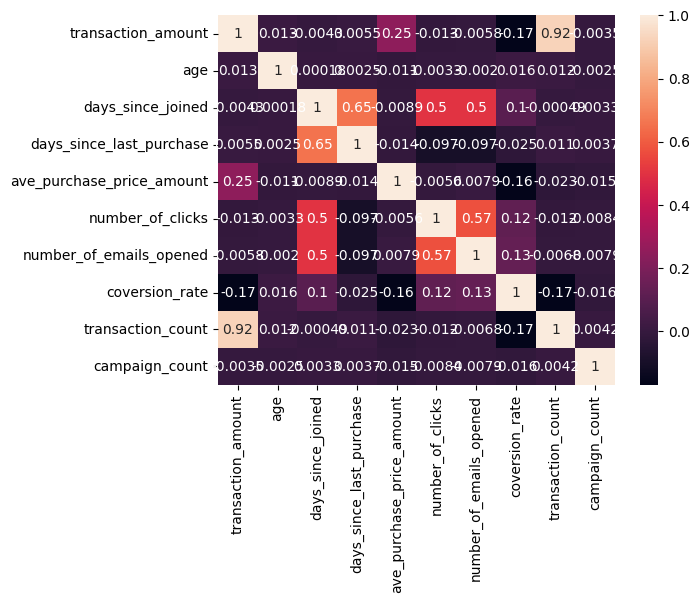

In [205]:
sns.heatmap(matrix, annot=True)